In [1]:
# conda activate sfmr
import os
import __init__ as f
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import CRS, Geod
import glob
from tqdm import tqdm
from pathlib import Path

In [2]:
# CAVEAT: 
# I have an error with this SFMR files:
# '/home/arthur/data/cyclobs/sfmr/noaa_nesdis_star/1.2.0/2021/SFMR210829US006_1-level2.nc'
# '/home/arthur/data/cyclobs/sfmr/noaa_nesdis_star/1.2.0/2021/SFMR210820US019-level2.nc'
# So I skipped it during my collocation procedure

In [3]:
### PATHS
PTHS = {
    'sat_dir':        '/home/arthur/data/**/KNMI/product_JF_rotated_filtered/POLAR/',
    'sfm_dir_noaa':   '/home/arthur/data/cyclobs/sfmr/noaa_aoml_hrd/',  
    'sfm_dir_nesdis': '/home/arthur/data/cyclobs/sfmr/noaa_nesdis_star/1.2.0/',
    'sav_dir':        '/home/arthur/data/cyclobs/sfmr/colloc_sfmr_radScat/'
}

### PARAMS
PRMS = {
    'delta_t': 120,                         # SFMR data will be cropped around +/- 120min around the satellite acquisition
    'r_ref':   np.linspace(0, 800000, 801), # Ref. grid
    'dr_min':  5000,                        # ds_sfmr after interpolation must contain valid values for radii lower  than 5,000 km
    'dr_max':  200000,                      # ds_sfmr after interpolation must contain valid values for radii higher than 200,000 km
    'save':    True
}

In [4]:
# # SFMR
# p_sfmr  = '/home/arthur/data/cyclobs/sfmr/noaa_aoml_hrd/2019/dorian/AFRC_SFMR20190830U3.nc'
# ds_sfmr = xr.open_dataset(p_sfmr)
# ds_sfmr = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
# print('Time interval: ', ds_sfmr.attrs['TimeInterval'])

In [5]:
# # SCAT or RAD
# p_sct  = '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered/POLAR/2019/AL052019/POL_ascat_20190831_013900_metopb_36063_srv_o_125_ovw.nc'
# ds_sct = xr.open_dataset(p_sct)
# P_SCT  = '/home/arthur/data/scatterometer/KNMI/product_JF/' + ds_sct.data_file.item()
# DS_SCT = xr.open_dataset(P_SCT)

In [6]:
# p = '/home/arthur/data/radiometer/KNMI/product_JF_rotated_filtered/POLAR/2019/AL052019/POL_SM_REPR_MIR_SCNFSW_20190904T100421_20190904T105819_300_301_7.nc'
# a = xr.open_dataset(p)

In [7]:
# def preprocess_time(t):
#     if len(t) == 5:
#         return '0' + t
#     else:
#         return t

def get_mission(pth):
    return pth.split('/')[6]

def get_var_names(pth):
    if get_mission(pth) == 'noaa_aoml_hrd':
        return ['LON', 'LAT', 'SWS']
    if get_mission(pth) == 'noaa_nesdis_star':
        return ['longitude', 'latitude', 'wind_speed']
    
def preprocess_sfmr(pth):
    # Open SFMR & get start/end dates
    if get_mission(pth) == 'noaa_aoml_hrd':
        subset    = ['DATE', 'TIME', 'LON', 'LAT', 'SWS']
        ds_sfmr   = xr.open_dataset(pth)[subset]
        ds_sfmr   = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
        sttDate   = ds_sfmr.DATE[0].astype(str).item()[:8]
        endDate   = ds_sfmr.DATE[-2].astype(str).item()[:8]
    if get_mission(pth) == 'noaa_nesdis_star':
        subset    = ['time', 'longitude', 'latitude', 'wind_speed']
        ds_sfmr   = xr.open_dataset(pth)[subset] 
        sttDate   = '{}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[0].data).year,  pd.to_datetime(ds_sfmr.time[0].data).month,  pd.to_datetime(ds_sfmr.time[0].data).day)
        endDate   = '{}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[-1].data).year, pd.to_datetime(ds_sfmr.time[-1].data).month, pd.to_datetime(ds_sfmr.time[-1].data).day)
        
    # Find satellite paths based on start and end dates of flight, and then concatenate (without duplicate values)
    sat_pths1 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(sttDate[:4], sttDate), recursive=True)
    sat_pths2 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(endDate[:4], endDate), recursive=True)
    sat_pths3 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
    sat_pths4 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
    sat_pths5 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
    sat_pths6 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
    sat_pths  = sorted(list(set(sat_pths1 + sat_pths2 + sat_pths3 + sat_pths4 + sat_pths5 + sat_pths6))) # remove duplicates

    # Start dateTime of SFMR
    if get_mission(pth) == 'noaa_aoml_hrd':
        # sttTime, endTime =  preprocess_time(ds_sfmr.TIME[0].astype(str).item()[:-2]), preprocess_time(ds_sfmr.TIME[-1].astype(str).item()[:-2])
        sttTime = '{:06d}'.format(ds_sfmr.TIME[0].astype(int).item())
        endTime = '{:06d}'.format(ds_sfmr.TIME[-1].astype(int).item())
        print(sttTime, endTime, endDate)
    if get_mission(pth) == 'noaa_nesdis_star':    
        sttTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[0].data).hour,  pd.to_datetime(ds_sfmr.time[0].data).minute,  pd.to_datetime(ds_sfmr.time[0].data).second)
        endTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[-1].data).hour, pd.to_datetime(ds_sfmr.time[-1].data).minute, pd.to_datetime(ds_sfmr.time[-1].data).second)  
    dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
    dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
    dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
    dtt_sfmr_end     = np.datetime64(dtt_str_end)

    return ds_sfmr, sat_pths, dtt_sfmr_stt, dtt_sfmr_end

In [8]:
# ds_sfmr = xr.open_dataset(sfm_pths[0])[['time', 'longitude', 'latitude', 'wind_speed']]

# # Find satellite paths based on start and end dates of flight, and then concatenate (without duplicate values)
# sat_pths1 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(sttDate[:4], sttDate), recursive=True)
# sat_pths2 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(endDate[:4], endDate), recursive=True)
# sat_pths3 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
# sat_pths4 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
# sat_pths5 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
# sat_pths6 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
# sat_pths  = sorted(list(set(sat_pths1 + sat_pths2 + sat_pths3 + sat_pths4 + sat_pths5 + sat_pths6))) # remove duplicates

# # Start dateTime of SFMR

# # dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
# # dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
# # dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
# # dtt_sfmr_end     = np.datetime64(dtt_str_end)

In [17]:
sfm_pths_noaa   = glob.glob(PTHS['sfm_dir_noaa'] + '**/*.nc', recursive=True)
sfm_pths_nesdis = glob.glob(PTHS['sfm_dir_nesdis'] + '**/*.nc', recursive=True)
sfm_pths        = sfm_pths_nesdis + sfm_pths_noaa # Reverse order once debugged
# subset          = ['DATE', 'TIME', 'LON', 'LAT', 'SWS']

for sfm_pth in tqdm(sfm_pths[103+106+204+574+59+130:]):
#     ds_sfmr = xr.open_dataset(sfm_pth)[subset]
#     ds_sfmr = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
#     sttDate = ds_sfmr.DATE[0].astype(str).item()[:8]
#     endDate = ds_sfmr.DATE[-1].astype(str).item()[:8]
#     # Find satellite paths based on start and end dates of flight, and then concatenate (without duplicate values)
#     sat_pths1 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(sttDate[:4], sttDate), recursive=True)
#     sat_pths2 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(endDate[:4], endDate), recursive=True)
#     sat_pths3 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
#     sat_pths4 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
#     sat_pths5 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
#     sat_pths6 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
#     sat_pths  = sorted(list(set(sat_pths1 + sat_pths2 + sat_pths3 + sat_pths4 + sat_pths5 + sat_pths6))) # remove duplicates
    
#     # Start dateTime of SFMR
#     sttTime, endTime =  preprocess_time(ds_sfmr.TIME[0].astype(str).item()[:-2]), preprocess_time(ds_sfmr.TIME[-1].astype(str).item()[:-2])
#     dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
#     dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
#     dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
#     dtt_sfmr_end     = np.datetime64(dtt_str_end)

    try:
        ds_sfmr, sat_pths, dtt_sfmr_stt, dtt_sfmr_end = preprocess_sfmr(sfm_pth)
        sfm_lon, sfm_lat, sfm_sws                     = get_var_names(sfm_pth)
        valid_sfm_file = True
    except IndexError as e:
        valid_sfm_file = False
    
    if valid_sfm_file:
        # Iterate over all candidates satellite files
        for i, sat_pth in enumerate(sat_pths):
            ds_sat = xr.open_dataset(sat_pth)
            dt_sfm_sat_stt = (ds_sat.acquisition_time - dtt_sfmr_stt) / np.timedelta64(1, 's') # Time diff. SAT - SFMR_START
            dt_sfm_sat_end = (ds_sat.acquisition_time - dtt_sfmr_end) / np.timedelta64(1, 's') # Time diff. SAT - SFMR_END
            if (dt_sfm_sat_stt >= 0) & (dt_sfm_sat_end <= 0): # SAT. acq. time must be in between
                if (abs(((ds_sfmr[sfm_lon] % 360).mean(skipna=True) - ds_sat.lon_IBT)) <= 10) & (abs(((ds_sfmr[sfm_lat]).mean(skipna=True) - ds_sat.lat_IBT)) <= 10): # check also that it's the same storm (lon, lat)
                    # Open Jeff's IBTrACS product (MAXSS version)
                    DS_SAT = xr.open_dataset('/'.join(sat_pth.split('/')[:6]) + '/product_JF/' + ds_sat.data_file.item())
                    track_df = pd.DataFrame(
                        data={
                            'datetime': DS_SAT.track_time,
                            'lon':      DS_SAT.__track_lon,
                            'lat':      DS_SAT.__track_lat,
                        }
                    )
                    # Get acquisition time
                    acq_time = ds_sat.acquisition_time.values
                    acq_time = pd.to_datetime(acq_time.astype('datetime64[s]')) # round to nearest second and convert to datetime object

                    # Put SFMR points on satellite points, accounting for storm translation
                    try:
                        sfmr_df  = f.prepare_sfmr(sfm_pth, track_df, acq_time)
                        valid    = True
                    except KeyError as e:
                        valid = False
                    if valid:
                        dss      = sfmr_df.to_xarray()
                        # Cropping at +/- 2hrs from satellite acquisition time
                        dss      = dss.where(abs((ds_sat.acquisition_time.values - dss.time) / np.timedelta64(1, 'm')) <= PRMS['delta_t'], drop=True)

                        # TODO: handle lon, lat 
                        dss[sfm_lon] = dss[sfm_lon] % 360

                        ### Get (r, theta) of SFMR from TC center 
                        # Convert (lon_center, lat_center) to array 
                        lons_center = np.ones_like(dss[sfm_lon]) * float(ds_sat.lon_IBT)
                        lats_center = np.ones_like(dss[sfm_lat]) * float(ds_sat.lat_IBT)
                        # Get the distance between target point and center point
                        geod_wgs84  = CRS("epsg:4326").get_geod()
                        _, _, dr    = geod_wgs84.inv(lons_center, lats_center, dss[sfm_lon], dss[sfm_lat])
                        if len(dr) > 0:
                            if (np.min(dr) <= PRMS['dr_min']) & (np.max(dr) >= PRMS['dr_max']):
                                # Change dss dim/coordinates
                                dss['time'] = dr
                                dss         = dss.rename_dims({'time': 'dr'}).rename({'time': 'dr'})
                                dss         = dss.interp({'dr': PRMS['r_ref']})

                                # Save
                                ds_col = xr.Dataset(
                                    data_vars={
                                        'sfmr_sws':         ('r', dss[sfm_sws].data),
                                        'vmx_IBT':          ds_sat.vmx_IBT.data,
                                        'rmx_IBT':          ds_sat.rmx_IBT.data,
                                        'r34_IBT':          ds_sat.r34_IBT.data,
                                        'r50_IBT':          ds_sat.r50_IBT.data,
                                        'r64_IBT':          ds_sat.r64_IBT.data,
                                        'lon_IBT':          ds_sat.lon_IBT.data,
                                        'lat_IBT':          ds_sat.lat_IBT.data,
                                        'storm_dir_IBT':    ds_sat.storm_dir_IBT.data,
                                        'storm_speed_IBT':  ds_sat.storm_speed_IBT.data,
                                        'atcf_id':          ds_sat.atcf_id.data,
                                        'sat_acq_time':     ds_sat.acquisition_time.data,
                                        'sat_file':         ds_sat.data_file.data,
                                        'sat_mission':      ds_sat.mission.data,
                                    },
                                    coords={
                                        'r': PRMS['r_ref']
                                    }
                                )

                                # print(i)
                                # ds_col.sfmr_sws.plot();plt.show()

                                if PRMS['save']:
                                    atcf_id = ds_sat.atcf_id.item()
                                    # print(atcf_id)
                                    # if atcf_id == 'AL132018':
                                    #     break
                                    p_sav   = Path(PTHS['sav_dir'] + '{}/{}/'.format(atcf_id[-4:], atcf_id))
                                    p_sav.mkdir(parents=True, exist_ok=True)
                                    ds_col.to_netcdf(PTHS['sav_dir'] + '{}/{}/{}_{}'.format(atcf_id[-4:], atcf_id, os.path.basename(sfm_pth)[:-3], os.path.basename(sat_pth)))
                                    # ds_col.to_netcdf(PTHS['sav_dir'] + '{}_{}'.format(os.path.basename(sfm_pth)[:-3], os.path.basename(sat_pth)))

  0%|          | 0/1495 [00:00<?, ?it/s]INFO:coloc_config.py:/home/arthur/data/cyclobs/sfmr/noaa_aoml_hrd/2019/dorian/NOAA_SFMR20190905H2.nc


195338 021250 20190906


INFO:coloc_config.py:timing sfmr_resample : 0.0s. mem: +0.0Mb
INFO:coloc_config.py:timing spatial_downsample : 0.0s. mem: +0.0Mb
INFO:coloc_config.py:timing sfmr_translate : 0.4s. mem: -13.9Mb
  0%|          | 0/1495 [00:10<?, ?it/s]


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

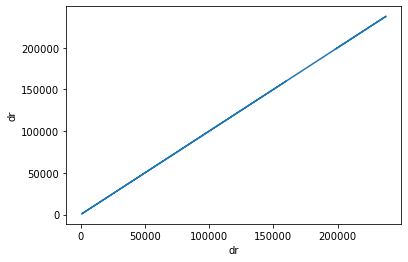

In [16]:
dss.dr.plot()

In [ ]:
xr.open_dataset(sfm_pth).TIME

In [ ]:
if get_mission(pth) == 'noaa_aoml_hrd':
    subset    = ['DATE', 'TIME', 'LON', 'LAT', 'SWS']
    ds_sfmr   = xr.open_dataset(pth)[subset]
    ds_sfmr   = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
    sttDate   = ds_sfmr.DATE[0].astype(str).item()[:8]
    endDate   = ds_sfmr.DATE[-1].astype(str).item()[:8]

In [ ]:
# Start dateTime of SFMR
if get_mission(pth) == 'noaa_aoml_hrd':
    # sttTime, endTime =  preprocess_time(ds_sfmr.TIME[0].astype(str).item()[:-2]), preprocess_time(ds_sfmr.TIME[-1].astype(str).item()[:-2])
    sttTime = '{:06d}'.format(ds_sfmr.TIME[0].item())
    endTime = '{:06d}'.format(ds_sfmr.TIME[-1].item())
if get_mission(pth) == 'noaa_nesdis_star':    
    sttTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[0].data).hour,  pd.to_datetime(ds_sfmr.time[0].data).minute,  pd.to_datetime(ds_sfmr.time[0].data).second)
    endTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[-1].data).hour, pd.to_datetime(ds_sfmr.time[-1].data).minute, pd.to_datetime(ds_sfmr.time[-1].data).second)  
dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
dtt_sfmr_end     = np.datetime64(dtt_str_end)

In [ ]:
ds_sfmr = xr.open_dataset(sfm_pth)
# preprocess_time(ds_sfmr.TIME[0].astype(str).item()[:-2]), preprocess_time(ds_sfmr.TIME[-1].astype(str).item()[:-2])

In [ ]:
'{:06d}'.format(ds_sfmr.TIME[0].item())

In [ ]:
ds_sfmr.TIME[-1]

In [ ]:
sttTime = '{:06d}'.format(ds_sfmr.TIME[0].astype(int).item())
endTime = '{:06d}'.format(ds_sfmr.TIME[-1].astype(int).item())

In [ ]:
d   = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
        # sttDate   = ds_sfmr.DATE[0].astype(str).item()[:8]
        # endDate   = ds_sfmr.DATE[-1].astype(str).item()[:8]

In [ ]:
endDate   = d.DATE[-2].astype(str).item()[:8]

In [ ]:
d.DATE[-2].astype(str).item()[:8]

In [ ]:
endDate

In [ ]:
'{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])

In [ ]:
# sfm_pths[103+106+204+574:]

In [ ]:
ds_sfmr.TIME

In [ ]:
'{:06d}'.format(ds_sfmr.TIME[0].item())

In [ ]:
sfm_pth

In [ ]:
p = '/home/arthur/data/cyclobs/sfmr/noaa_nesdis_star/1.2.0/2021/SFMR210829US006_2-level2.nc'

In [ ]:
xr.open_dataset(p)

In [ ]:
xr.open_dataset('/home/arthur/data/cyclobs/sfmr/noaa_nesdis_star/1.2.0/2021/SFMR210820US019-level2.nc')

In [ ]:
preprocess_sfmr(sfm_pth)

In [ ]:
def preprocess_sfmr(pth):
    # Open SFMR & get start/end dates
    if get_mission(pth) == 'noaa_aoml_hrd':
        subset    = ['DATE', 'TIME', 'LON', 'LAT', 'SWS']
        ds_sfmr   = xr.open_dataset(pth)[subset]
        ds_sfmr   = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
        sttDate   = ds_sfmr.DATE[0].astype(str).item()[:8]
        endDate   = ds_sfmr.DATE[-1].astype(str).item()[:8]
    if get_mission(pth) == 'noaa_nesdis_star':
        subset    = ['time', 'longitude', 'latitude', 'wind_speed']
        ds_sfmr   = xr.open_dataset(pth)[subset] 
        sttDate   = '{}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[0].data).year,  pd.to_datetime(ds_sfmr.time[0].data).month,  pd.to_datetime(ds_sfmr.time[0].data).day)
        endDate   = '{}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[-1].data).year, pd.to_datetime(ds_sfmr.time[-1].data).month, pd.to_datetime(ds_sfmr.time[-1].data).day)
        
    # Find satellite paths based on start and end dates of flight, and then concatenate (without duplicate values)
    sat_pths1 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(sttDate[:4], sttDate), recursive=True)
    sat_pths2 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(endDate[:4], endDate), recursive=True)
    sat_pths3 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
    sat_pths4 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
    sat_pths5 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
    sat_pths6 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
    sat_pths  = sorted(list(set(sat_pths1 + sat_pths2 + sat_pths3 + sat_pths4 + sat_pths5 + sat_pths6))) # remove duplicates

    # Start dateTime of SFMR
    if get_mission(pth) == 'noaa_aoml_hrd':
        sttTime, endTime =  preprocess_time(ds_sfmr.TIME[0].astype(str).item()[:-2]), preprocess_time(ds_sfmr.TIME[-1].astype(str).item()[:-2])
    if get_mission(pth) == 'noaa_nesdis_star':    
        sttTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[0].data).hour,  pd.to_datetime(ds_sfmr.time[0].data).minute,  pd.to_datetime(ds_sfmr.time[0].data).second)
        endTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[-1].data).hour, pd.to_datetime(ds_sfmr.time[-1].data).minute, pd.to_datetime(ds_sfmr.time[-1].data).second)  
    dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
    dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
    dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
    dtt_sfmr_end     = np.datetime64(dtt_str_end)

    return ds_sfmr, sat_pths, dtt_sfmr_stt, dtt_sfmr_end

In [ ]:
subset    = ['time', 'longitude', 'latitude', 'wind_speed']
ds_sfmr   = xr.open_dataset(sfm_pth)[subset] 

In [ ]:
ds_sfmr